In [103]:
import numpy as np
import os
import csv
import json

# import matplotlib.pyplot as plt
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy import interpolate

## Variables
These variables may change:

In [104]:
basedir = "/mnt/adata9/"

animal_name='JC274'
date='20220304'

mbasedir="/adata_pool/merged/"+animal_name+'-'+date+'/'

Import session metadata:

In [105]:
session_metadata = {}
with open('session_metadata.csv', mode='r', encoding='utf-8') as file:
    reader = csv.DictReader(file, delimiter=";")    
    for line in reader:
        session_id = line.pop('session_id')
        session_metadata[session_id] = line
        
basename = animal_name+'-'+date

In [106]:
reward_arms = session_metadata[basename]['reward_arms']
num_tetrodes = int(session_metadata[basename]['num_tetr'])
session_idx = json.loads(session_metadata[basename]['session_idx'])
session_names_str = session_metadata[basename]['session_names']
session_names_str = session_names_str.replace("'",'"') # the single quotes aren't being read in JSON, but I can't use " in the csv because it's a str delimiter
session_names = json.loads(session_names_str)


session_metadata[basename]

{'num_tetr': '25',
 'last_pfc_left': '8',
 'last_pfc_right': '14',
 'session_names': "['training1','intersleep','training2']",
 'session_idx': '[[1,2],[3],[4]]',
 'reward_arms': '[7 3 2]',
 'rewards': '[C H S]'}

In [101]:
reward_arms


array('[7 3 2]', dtype='<U7')

In [102]:
type(reward_arms)

numpy.ndarray

These variables do not change:

In [34]:
sample_rate_res_old=24000

sample_rate_whl=39.0625
sample_rate_res=20000

sample_rate_eegh=5000

downsampled_res=sample_rate_res/sample_rate_res_old

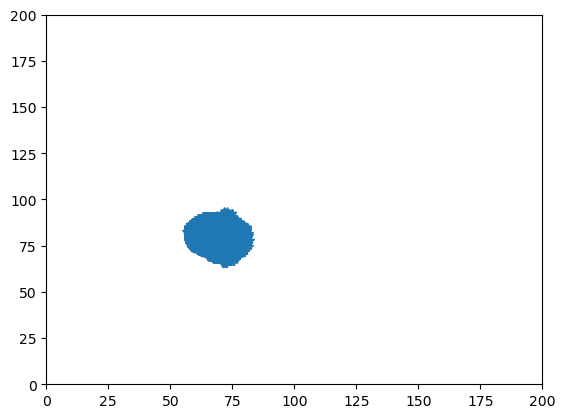

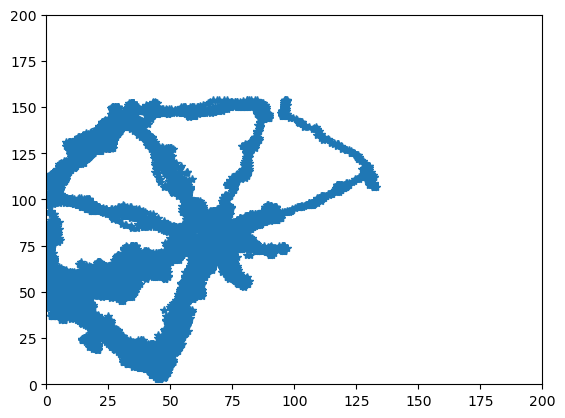

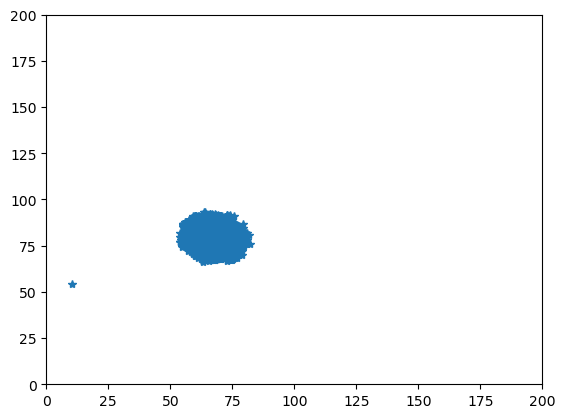

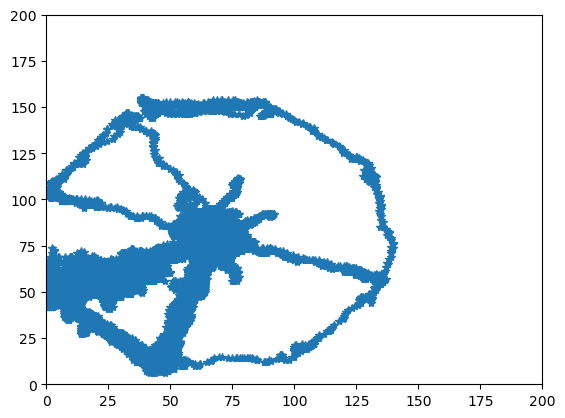

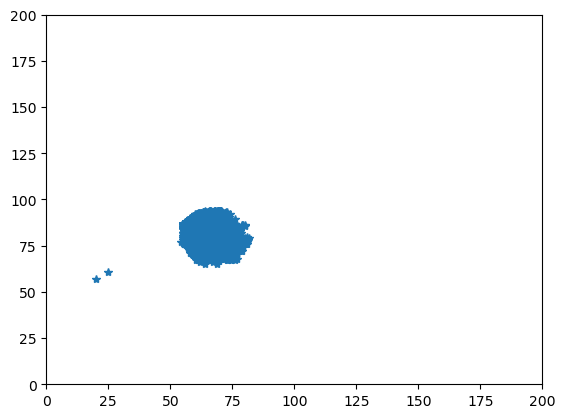

In [8]:
sort_arg=np.argsort(res)

res=res[sort_arg]
clu=clu[sort_arg]

res_down=res*downsampled_res
session_timestamps_down=session_timestamps*downsampled_res


for i in range(len(session_idx)):

    # Return the first and last recording of a session type
    if len(session_idx[i])>0:
        start_cut=session_idx[i][0]-1
        end_cut=session_idx[i][-1]

        index1=res_down<session_timestamps_down[end_cut]
        index2=res_down>session_timestamps_down[start_cut]
        #test=np.logical_and(index1,index2)
        clu_temp=clu[np.logical_and(res_down<session_timestamps_down[end_cut],res_down>session_timestamps_down[start_cut])]
        res_temp=res_down[np.logical_and(res_down<session_timestamps_down[end_cut],res_down>session_timestamps_down[start_cut])]

        res_temp=res_temp-session_timestamps_down[start_cut]
        clu_temp = np.insert(clu_temp, 0, starting_cell_ind, axis=0)

        np.savetxt(mbasedir+animal_name+'-'+date+'_'+session_names[i]+'.res', res_temp.astype(int), fmt='%i')
        np.savetxt(mbasedir+animal_name+'-'+date+'_'+session_names[i]+'.clu', clu_temp.astype(int), fmt='%i')

        start_whl=int(session_timestamps_down[start_cut]/sample_rate_res*sample_rate_whl)
        end_whl=int(session_timestamps_down[end_cut]/sample_rate_res*sample_rate_whl)
        whl_temp=whl_new[start_whl:end_whl]

        np.savetxt(mbasedir+animal_name+'-'+date+'_'+session_names[i]+'.whl', whl_temp.astype(int), fmt='%i')

        plt.plot(whl_temp[:,0],whl_temp[:,1],'*')
        plt.xlim([0,200])
        plt.ylim([0,200])
        plt.show()



with open(mbasedir+animal_name+'-'+date+'.des', 'w') as fp:
    fp.write('\n'.join(des))

with open(mbasedir+animal_name+'-'+date+'.des_full', 'w') as fp:
    fp.write('\n'.join(des_full))

## Merge and split EEGH files and add reward arm files

In [95]:
def find_files_with_eegh(directory):
    eegh_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if 'eegh' in file:
                eegh_files.append(os.path.join(root, file))
    return eegh_files

##############################################################
# basedir='D:\github/test/'
# mbasedir="D:\github/test\merged"+animal_name+'-'+date+'/'
# if not os.path.isdir(mbasedir):
#     os.makedirs(mbasedir)

directory_path_eegh = basedir+"eeg/"+animal_name+'/'+date+'/'
###########################################################

eegh_files = find_files_with_eegh(directory_path_eegh)

eegh_merged=np.fromfile(eegh_files[0], dtype=np.int16)
eegh_merged= eegh_merged.reshape( int(len(eegh_merged)/num_tetrodes),num_tetrodes)



for eegh_file_i in range(1,len(eegh_files)):
    eegh_t=np.fromfile(eegh_files[eegh_file_i], dtype=np.int16)
    eegh_t= eegh_t.reshape( int(len(eegh_t)/num_tetrodes),num_tetrodes)
    eegh_merged=np.append(eegh_merged,eegh_t,axis=0)

length_eegh_merged=eegh_merged.shape[0]


session_timestamps=np.loadtxt(basedir+"processing/"+animal_name+'/'+date+'/'+'session_shifts.txt')
session_timestamps=np.append([0],session_timestamps) # start the first timestamp at 0

session_timestamps_down=session_timestamps*downsampled_res

for session_idx_i in range(len(session_idx)):

    if session_names[session_idx_i]=='training1' or session_names[session_idx_i]=='training2':
        reward_arms=np.array(session_metadata[basename]['reward_arms']).T
        np.savetxt(mbasedir+animal_name+'-'+date+'_'+session_names[session_idx_i]+'.reward_arms', reward_arms.astype(int), fmt='%i',newline=" ")


    start_cut=session_idx[session_idx_i][0]-1
    end_cut=session_idx[session_idx_i][-1]
    start_eegh=int(session_timestamps_down[start_cut]/sample_rate_res*sample_rate_eegh)
    end_eegh=int(session_timestamps_down[end_cut]/sample_rate_res*sample_rate_eegh)


    eegh_temp=eegh_merged[start_eegh:end_eegh,:]

    eegh_temp.tofile(mbasedir+animal_name+'-'+date+'_'+session_names[session_idx_i]+'.eegh')

ValueError: invalid literal for int() with base 10: '[7 3 2]'

In [40]:
directory_path_eegh

'/mnt/adata9/processing/eeg/JC274/20220304/'